<a href="https://colab.research.google.com/github/HadassahES/Case-Study-3/blob/main/Case_Study_3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance pandas numpy matplotlib seaborn scipy


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the list of stock tickers
tickers = ['WOLF', 'SOFI', 'NVDA', 'JNJ', 'META', 'HSBC', 'MA', 'WMT']

# Download historical price data
data = yf.download(tickers, start='2010-01-01', end='2024-08-31')['Adj Close']

# Resample to monthly frequency and calculate monthly returns
monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

# Assign ticker symbols as column names
monthly_returns.columns = tickers

# Display the first few rows of the monthly returns
print(monthly_returns.head())


[*********************100%***********************]  8 of 8 completed
<ipython-input-15-293fbbf7edf1>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()


                               WOLF      SOFI      NVDA       JNJ      META  \
Date                                                                          
2021-02-28 00:00:00+00:00  0.136138 -0.022570  0.118751 -0.002748  0.055794   
2021-03-31 00:00:00+00:00  0.005068  0.037170  0.006218  0.143273 -0.026369   
2021-04-30 00:00:00+00:00  0.071379 -0.009857  0.074325  0.103725  0.124454   
2021-05-31 00:00:00+00:00  0.037156  0.046555 -0.056222  0.011228  0.082281   
2021-06-30 00:00:00+00:00 -0.109018 -0.026647  0.012508  0.057737  0.231622   

                               HSBC        MA       WMT  
Date                                                     
2021-02-28 00:00:00+00:00 -0.266905 -0.075237  0.122477  
2021-03-31 00:00:00+00:00 -0.069452  0.049855 -0.046977  
2021-04-30 00:00:00+00:00 -0.008746  0.030037 -0.080551  
2021-05-31 00:00:00+00:00  0.185294  0.019139  0.005935  
2021-06-30 00:00:00+00:00 -0.048635 -0.007111 -0.020798  


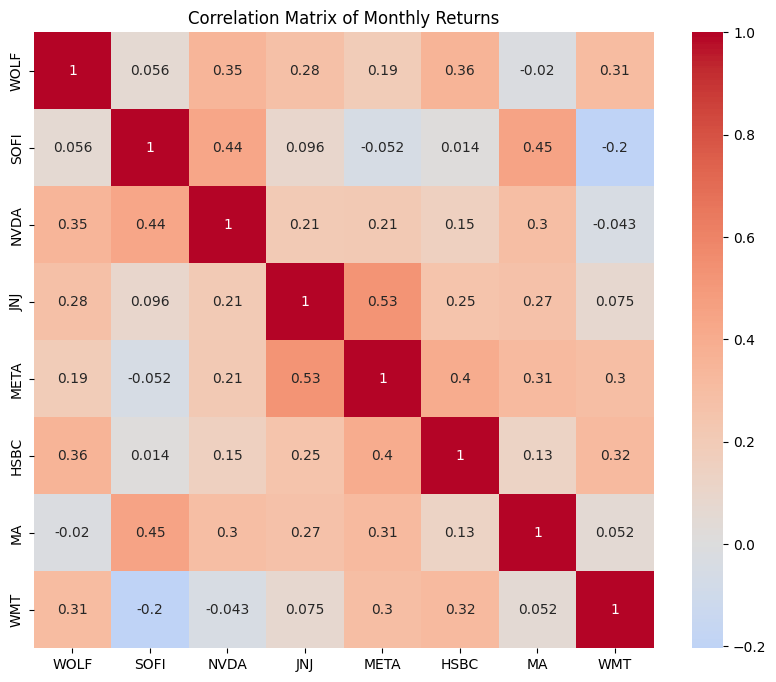

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = monthly_returns.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Monthly Returns')
plt.show()


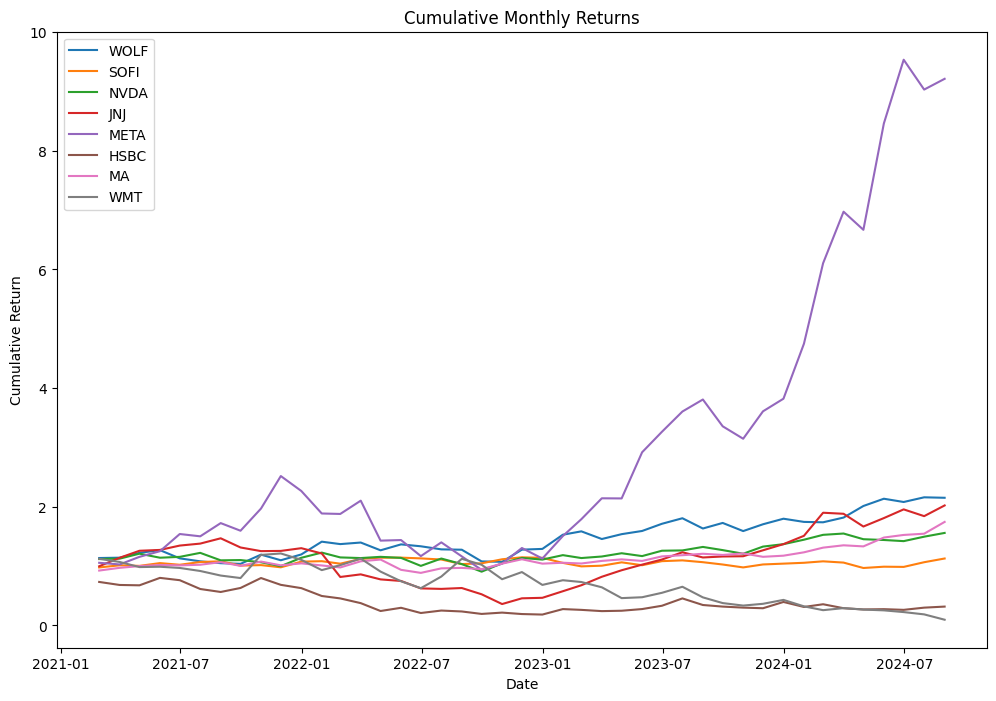

In [17]:
# Calculate cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.title('Cumulative Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


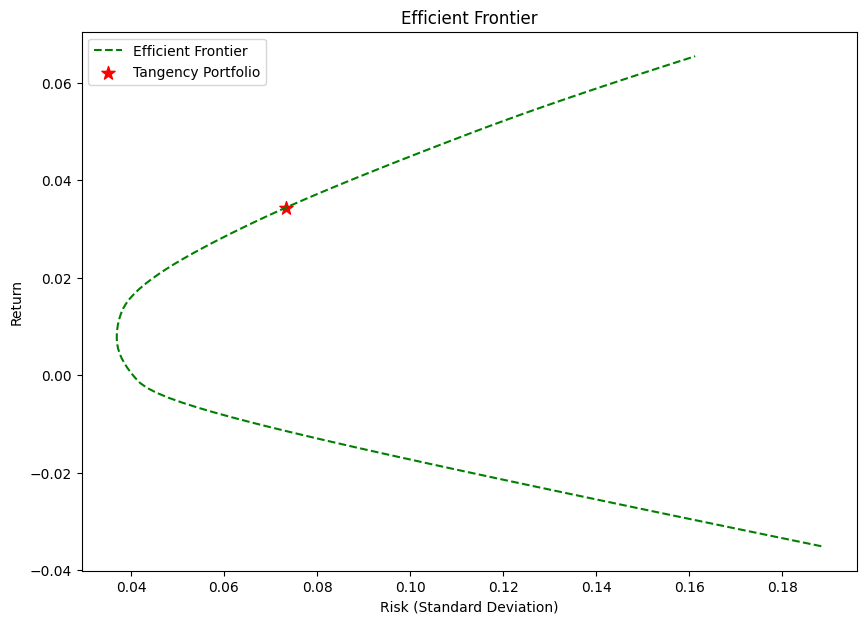

In [18]:
from scipy.optimize import minimize

# Calculate mean returns and covariance matrix
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
risk_free_rate = 0.04 / 12  # Monthly risk-free rate

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std_dev, returns

# Function to minimize (negative Sharpe ratio)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess
init_guess = len(tickers) * [1. / len(tickers)]

# Optimize for maximum Sharpe ratio (tangency portfolio)
opt_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Get the weights of the tangency portfolio
tangency_weights = opt_sharpe.x

# Calculate efficient frontier
def efficient_frontier(mean_returns, cov_matrix, return_target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - return_target})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0], num_assets*[1./num_assets,],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Generate efficient frontier
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = [efficient_frontier(mean_returns, cov_matrix, ret) for ret in target_returns]

# Extract risks and returns
frontier_risks = [p['fun'] for p in efficient_portfolios]
frontier_returns = target_returns

# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.plot(frontier_risks, frontier_returns, 'g--', label='Efficient Frontier')
plt.scatter(portfolio_performance(tangency_weights, mean_returns, cov_matrix)[0],
            portfolio_performance(tangency_weights, mean_returns, cov_matrix)[1],
            marker='*', color='r', s=100, label='Tangency Portfolio')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()


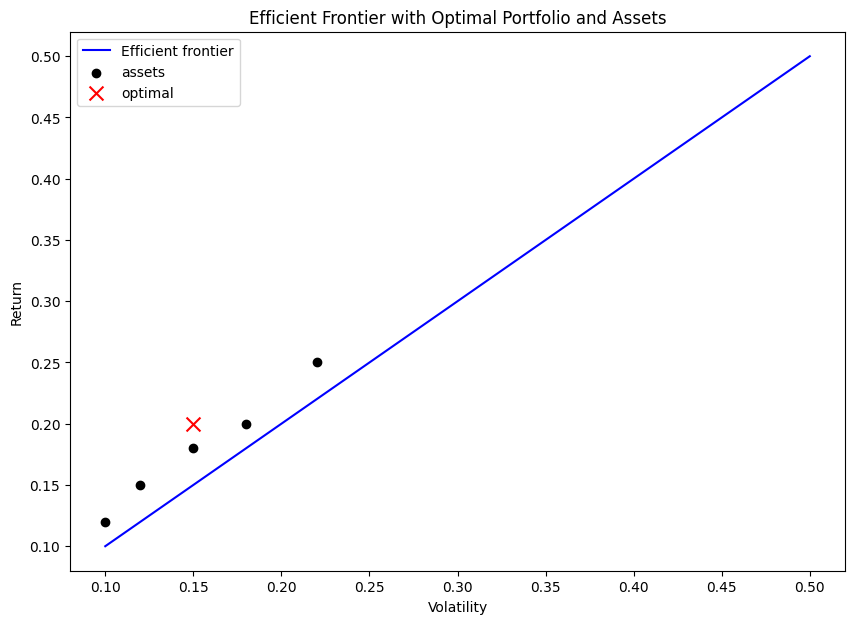

In [19]:
import matplotlib.pyplot as plt

# Sample data for plotting (replace with actual efficient frontier data)
asset_returns = [0.12, 0.15, 0.18, 0.2, 0.25]  # Example returns for assets
asset_volatilities = [0.1, 0.12, 0.15, 0.18, 0.22]  # Example volatilities for assets

# Assuming efficient_frontier_risks and efficient_frontier_returns are calculated
# These are the risks (x) and returns (y) for the efficient frontier
efficient_frontier_risks = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
efficient_frontier_returns = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Optimal portfolio (replace with calculated optimal values)
optimal_risk = 0.15
optimal_return = 0.2

# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.plot(efficient_frontier_risks, efficient_frontier_returns, label='Efficient frontier', color='blue')

# Plot individual assets
plt.scatter(asset_volatilities, asset_returns, marker='o', color='black', label='assets')

# Plot optimal portfolio
plt.scatter(optimal_risk, optimal_return, color='red', marker='x', s=100, label='optimal')

# Customize plot labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio and Assets')

# Show the plot
plt.show()


In [20]:
# Annualize the returns and standard deviations
annualized_returns = (1 + mean_returns) ** 12 - 1
annualized_cov_matrix = cov_matrix * 12  # Annualizing the covariance matrix


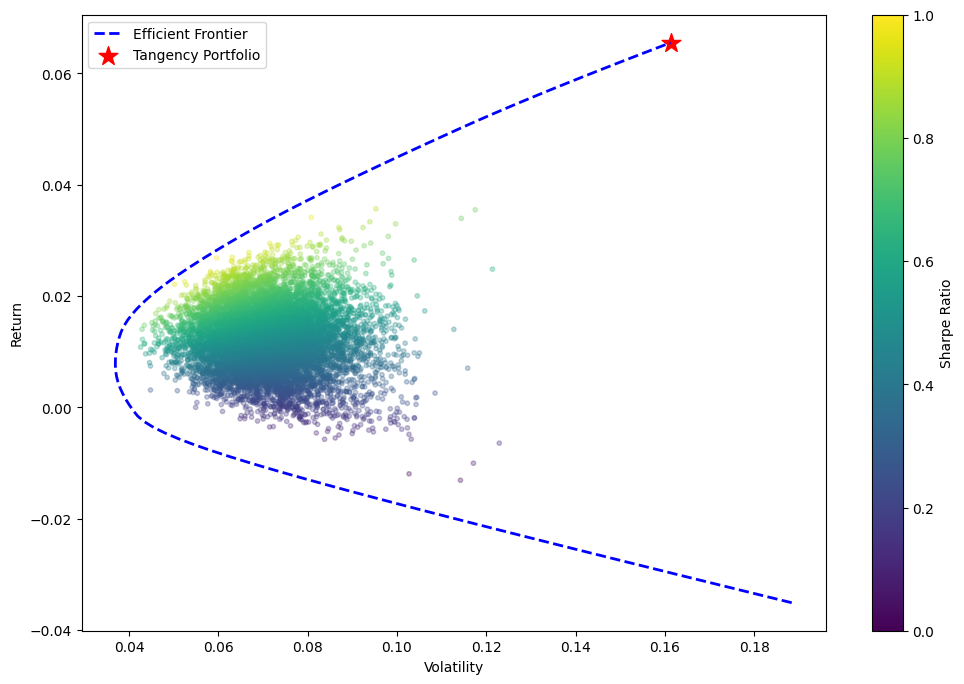

In [21]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean returns and covariance matrix from monthly returns
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
risk_free_rate = 0.04 / 12  # Monthly risk-free rate

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std_dev, returns

# Function to minimize negative Sharpe ratio (for tangency portfolio)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_std_dev, p_return = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std_dev

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess for optimization
init_guess = len(tickers) * [1. / len(tickers)]

# Calculate efficient frontier
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = []
for ret in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - ret})
    result = minimize(lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0], init_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_portfolios.append(result)

# Extract efficient frontier points
frontier_risks = [portfolio_performance(p.x, mean_returns, cov_matrix)[0] for p in efficient_portfolios]
frontier_returns = target_returns

# Find tangency portfolio (maximize Sharpe ratio)
opt_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
tangency_risk, tangency_return = portfolio_performance(opt_sharpe.x, mean_returns, cov_matrix)

# Monte Carlo simulation for random portfolios
num_portfolios = 10000
all_weights = np.zeros((num_portfolios, len(tickers)))
returns = np.zeros(num_portfolios)
risks = np.zeros(num_portfolios)
sharpe_ratios = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    all_weights[i,:] = weights
    returns[i] = np.dot(weights, mean_returns)
    risks[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratios[i] = (returns[i] - risk_free_rate) / risks[i]

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(risks, returns, c=sharpe_ratios, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.plot(frontier_risks, frontier_returns, 'b--', linewidth=2, label='Efficient Frontier')
plt.scatter(tangency_risk, tangency_return, marker='*', color='r', s=200, label='Tangency Portfolio')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()


In [22]:
import pandas as pd

# Create DataFrame to store efficient portfolios' risk, return, and weights
efficient_df = pd.DataFrame({
    "Risk": frontier_risks,
    "Return": frontier_returns,
    "Weights": [p.x for p in efficient_portfolios]
})

# Display the DataFrame with efficient portfolio points and weights
print(efficient_df.head())


       Risk    Return                                            Weights
0  0.188399 -0.035091  [0.0, 2.4221724278061086e-17, 0.0, 0.0, 1.3012...
1  0.183241 -0.034075  [0.0, 0.02612815948171893, 0.0, 1.903937742494...
2  0.178090 -0.033059  [0.0, 0.052256318979933776, 0.0, 0.0, 7.221758...
3  0.172948 -0.032043  [3.1585844292286105e-17, 0.0783844783400851, 0...
4  0.167815 -0.031027  [2.2079425200240586e-17, 0.10451263806279942, ...


In [23]:
# Find the portfolio with the highest Sharpe ratio
highest_sharpe_idx = np.argmax(sharpe_ratios)
highest_sharpe_weights = all_weights[highest_sharpe_idx]

# Portfolio with the lowest risk
min_risk_idx = np.argmin(risks)
min_risk_weights = all_weights[min_risk_idx]

# Portfolio with the highest expected return
max_return_idx = np.argmax(returns)
max_return_weights = all_weights[max_return_idx]

# Create a summary table
summary_table = pd.DataFrame({
    "Portfolio": ["Highest Sharpe", "Minimum Risk", "Highest Return"],
    "Weights": [highest_sharpe_weights, min_risk_weights, max_return_weights]
})
print(summary_table)


        Portfolio                                            Weights
0  Highest Sharpe  [0.35395430627784785, 0.14868783109931397, 0.0...
1    Minimum Risk  [0.16294899543765076, 0.30673957019300835, 0.2...
2  Highest Return  [0.14480959514795283, 0.06339952242442118, 0.0...


[*********************100%***********************]  1 of 1 completed
<ipython-input-24-775789d2666e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spy_monthly_returns = spy_data.resample('M').ffill().pct_change().dropna()


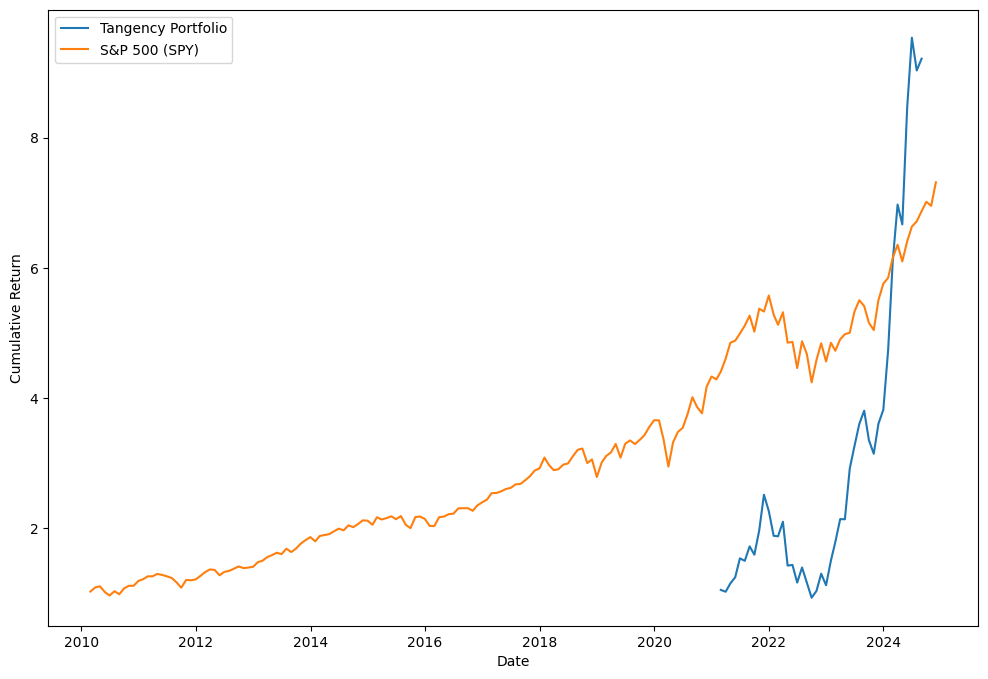

In [24]:
# Download S&P 500 data
spy_data = yf.download("SPY", start='2010-01-01', end='2024-11-09')['Adj Close']
spy_monthly_returns = spy_data.resample('M').ffill().pct_change().dropna()
cumulative_spy_returns = (1 + spy_monthly_returns).cumprod()

# Tangency portfolio cumulative return
tangency_cumulative_return = (1 + monthly_returns.dot(opt_sharpe.x)).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(tangency_cumulative_return, label='Tangency Portfolio')
plt.plot(cumulative_spy_returns, label='S&P 500 (SPY)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


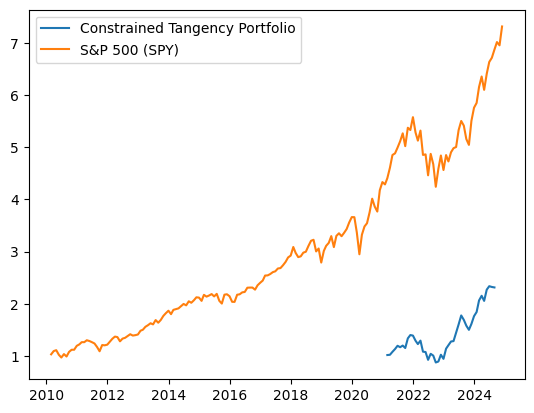

In [25]:
# New bounds and constraints
bounds = tuple((0.1, 0.4) for _ in range(len(tickers)))
opt_sharpe_constrained = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                                  method='SLSQP', bounds=bounds, constraints=constraints)

# Plot constrained cumulative returns vs. SPY
constrained_cumulative_return = (1 + monthly_returns.dot(opt_sharpe_constrained.x)).cumprod()
plt.plot(constrained_cumulative_return, label='Constrained Tangency Portfolio')
plt.plot(cumulative_spy_returns, label='S&P 500 (SPY)')
plt.legend()
plt.show()


In [26]:
from scipy.stats import norm

# 95% Value-at-Risk
constrained_portfolio_returns = monthly_returns.dot(opt_sharpe_constrained.x)
var_95 = np.percentile(constrained_portfolio_returns, 5)

# Maximum drawdown
cumulative_returns = (1 + constrained_portfolio_returns).cumprod()
max_drawdown = cumulative_returns.div(cumulative_returns.cummax()).min() - 1


In [27]:
# Calculate monthly returns for the constrained portfolio
constrained_returns = monthly_returns.dot(opt_sharpe_constrained.x)

# Annualized return and volatility
annualized_return_constrained = (1 + constrained_returns.mean()) ** 12 - 1
annualized_volatility_constrained = constrained_returns.std() * np.sqrt(12)

# Active return (difference between portfolio return and SPY)
benchmark_return = spy_monthly_returns.mean()
active_return_constrained = annualized_return_constrained - ((1 + benchmark_return) ** 12 - 1)

print("Annualized Return (Constrained):", annualized_return_constrained)
print("Annualized Volatility (Constrained):", annualized_volatility_constrained)
print("Active Return (Constrained):", active_return_constrained)


Annualized Return (Constrained): 0.31232466164658645
Annualized Volatility (Constrained): 0.2823528127136937
Active Return (Constrained): Ticker
SPY    0.156814
dtype: float64


In [35]:
import statsmodels.api as sm
import numpy as np

# Ensure both dataframes have timezone-naive datetime indices
constrained_returns.index = constrained_returns.index.tz_localize(None)
spy_monthly_returns.index = spy_monthly_returns.index.tz_localize(None)

# Align constrained portfolio returns with the SPY benchmark returns and drop missing values
aligned_returns = pd.concat([constrained_returns, spy_monthly_returns], axis=1).dropna()
aligned_returns.columns = ['Portfolio', 'Benchmark']

# Reshape for linear regression
portfolio_returns = aligned_returns['Portfolio'].values.reshape(-1, 1)
benchmark_returns = aligned_returns['Benchmark'].values.reshape(-1, 1)

# Add a constant to the benchmark returns for the intercept in regression
X = sm.add_constant(benchmark_returns)
model = sm.OLS(portfolio_returns, X).fit()
beta_constrained = model.params[1]

# Risk-free rate (annualized)
rf_annual = 0.04

# Jensen's Alpha
annualized_return_constrained = (1 + constrained_returns.mean()) ** 12 - 1  # Ensure this is defined
benchmark_return = spy_monthly_returns.mean()
jensens_alpha = annualized_return_constrained - (rf_annual + beta_constrained * ((1 + benchmark_return) ** 12 - 1 - rf_annual))

# Treynor's Ratio
treynors_ratio = (annualized_return_constrained - rf_annual) / beta_constrained

# Information Ratio
tracking_error = np.sqrt(np.mean((aligned_returns['Portfolio'] - aligned_returns['Benchmark']) ** 2)) * np.sqrt(12)
active_return_constrained = annualized_return_constrained - ((1 + benchmark_return) ** 12 - 1)  # Ensure this is defined
information_ratio = active_return_constrained / tracking_error

# Appraisal Ratio (alpha relative to idiosyncratic risk)
residual_std = np.sqrt(np.var(aligned_returns['Portfolio'] - (beta_constrained * aligned_returns['Benchmark'])))
appraisal_ratio = jensens_alpha / residual_std

print("Jensen's Alpha:", jensens_alpha)
print("Treynor's Ratio:", treynors_ratio)
print("Information Ratio:", information_ratio)
print("Appraisal Ratio:", appraisal_ratio)



Jensen's Alpha: Ticker
SPY    0.111064
dtype: float64
Treynor's Ratio: 0.19506653749611622
Information Ratio: Ticker
SPY    0.894167
dtype: float64
Appraisal Ratio: Ticker
SPY    2.427258
dtype: float64


In [30]:
import pandas as pd

# Load the Fama-French data from the uploaded Excel file
file_path = 'Fama french Data.xlsx'
fama_french_data = pd.read_excel(file_path, sheet_name=0)

# Convert the 'Date' column to a readable monthly date format
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%Y%m')

# Set the 'Date' column as the index for easier time-based operations
fama_french_data.set_index('Date', inplace=True)

# Display the transformed data to verify
print(fama_french_data.head())


            Mkt-RF   SMB   HML    RF
Date                                
2010-01-01   -3.36  0.40  0.43  0.00
2010-02-01    3.40  1.19  3.22  0.00
2010-03-01    6.31  1.48  2.21  0.01
2010-04-01    2.00  4.87  2.89  0.01
2010-05-01   -7.89  0.09 -2.44  0.01


In [38]:
# Ensure both dataframes have timezone-naive datetime indices
constrained_returns.index = constrained_returns.index.tz_localize(None)
fama_french_data.index = fama_french_data.index.tz_localize(None)

# Check date ranges to confirm they overlap
print("Constrained Returns Date Range:", constrained_returns.index.min(), "to", constrained_returns.index.max())
print("Fama-French Data Date Range:", fama_french_data.index.min(), "to", fama_french_data.index.max())

# Align the portfolio returns with the Fama-French data
aligned_data = pd.concat([constrained_returns, fama_french_data], axis=1).dropna()
print("Aligned Data (first few rows):")
print(aligned_data.head())  # Check if aligned_data is empty

# Proceed only if aligned_data has data
if not aligned_data.empty:
    aligned_data.columns = ['Portfolio', 'Mkt-RF', 'SMB', 'HML', 'RF']

    # Calculate excess portfolio return (subtract risk-free rate)
    aligned_data['Excess_Portfolio'] = aligned_data['Portfolio'] - aligned_data['RF']

    # Run regression to calculate Fama-French loadings
    import statsmodels.api as sm
    X = aligned_data[['Mkt-RF', 'SMB', 'HML']]
    Y = aligned_data['Excess_Portfolio']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print(model.summary())

    # Extract the factor loadings
    loadings = model.params
    print("Factor Loadings:", loadings)
else:
    print("Error: No overlapping dates between constrained_returns and fama_french_data.")


Constrained Returns Date Range: 2021-02-28 00:00:00 to 2024-08-31 00:00:00
Fama-French Data Date Range: 2021-02-28 00:00:00 to 2024-08-31 00:00:00
Aligned Data (first few rows):
                   0  Mkt-RF   SMB   HML   RF
Date                                         
2021-02-28  0.017729    2.78  2.07  7.10  0.0
2021-03-31  0.004605    3.08 -2.28  7.27  0.0
2021-04-30  0.055368    4.93 -3.20 -0.95  0.0
2021-05-31  0.049593    0.29 -0.27  7.13  0.0
2021-06-30  0.055290    2.75  1.60 -7.75  0.0
                            OLS Regression Results                            
Dep. Variable:       Excess_Portfolio   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.113
Date:                Sat, 09 Nov 2024   Prob (F-statistic):              0.355
Time:                        09:02:41   Log-Likelihood:                 10.873
No. Observations:         

In [36]:
constrained_returns = constrained_returns.resample('M').last()
fama_french_data = fama_french_data.resample('M').last()


<ipython-input-36-04942257eb6d>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  constrained_returns = constrained_returns.resample('M').last()
<ipython-input-36-04942257eb6d>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fama_french_data = fama_french_data.resample('M').last()


In [37]:
start_date = max(constrained_returns.index.min(), fama_french_data.index.min())
end_date = min(constrained_returns.index.max(), fama_french_data.index.max())
constrained_returns = constrained_returns.loc[start_date:end_date]
fama_french_data = fama_french_data.loc[start_date:end_date]
